In [3]:
from regen.dataset import DynamicDamageDataset
from regen.model import NCA3DDamageDetection
from regen.trainer import NCA3DTrainer
from regen.utils import plot_voxels, save_weights
import numpy as np
import torch
import torch.nn.functional as F

In [4]:
a = torch.ones((1, 3, 3, 3, 20)) * 2.0
b = torch.ones((1, 3, 3, 3, 20))
a = F.mse_loss(a, b, reduction='none').sum(dim=-1)

### Load dataset

In [5]:
import torch
import torch.nn.functional as F

In [7]:
a = torch.rand((4, 3))
b = torch.rand((4, 3))


In [8]:
F.mse_loss(a, b, reduction='none')

tensor([[2.1218e-01, 1.3836e-01, 1.6893e-02],
        [6.5912e-02, 4.1192e-05, 6.1219e-02],
        [1.9144e-01, 1.9737e-01, 7.8769e-02],
        [3.8191e-01, 1.3297e-01, 8.0527e-02]])

In [9]:
labels = np.load('../data/ydata_7class.npy')
shapes = np.load('../data/xdata_7class.npy')

In [6]:
dataset = DynamicDamageDataset(shapes, labels, damage_radius_range=(1, 3), damage_types=["sphere", "cube", "random"], random_proportion_range=(0.1, 0.2), fixed_damage=False, augment_rotations=False, return_damage_mask=True, seed=None, filter_label=1)

NameError: name 'shapes' is not defined

In [7]:
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

def plot_voxels(live_mask, damage_direction, add_shadow=True, shadow_offset=5, label="3d damage", legend=True, alpha=0.7):
    """
    Plot a 3D visualization of the live mask with damage directions.

    Args:
        live_mask: 3D numpy array where 1 represents live cells and 0 represents dead cells
        damage_direction: 3D array indicating direction of nearby damage (0-6)
        add_shadow: Whether to add a red shadow copy behind the shape
        shadow_offset: How far behind to place the shadow in the y-axis
        label: Title for the plot
        legend: Whether to show the legend
        alpha: Transparency level for the voxels (0.0 to 1.0)
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Define color map for damage directions
    color_map = {
        0: "blue",  # No damage direction
        1: "gray",  # Damage in -x direction
        2: "orange",  # Damage in +x direction
        3: "purple",  # Damage in -y direction
        4: "pink",  # Damage in +y direction
        5: "yellow",  # Damage in -z direction
        6: "black",  # Damage in +z direction
    }

    # Convert live_mask to boolean if it's not already
    live_mask_bool = live_mask.astype(bool)
    
    if add_shadow:
        # Find the maximum y-coordinate where the shape exists
        max_y = 0
        for y in range(live_mask.shape[1]):
            if np.any(live_mask_bool[:, y, :]):
                max_y = max(max_y, y)
        
        # Calculate where to place the shadow (completely behind the original shape)
        shadow_start = max_y + 1
        total_y_size = shadow_start + shadow_offset + live_mask.shape[1]
        
        # Create a larger array to accommodate the shadow in y-axis
        extended_mask = np.zeros((live_mask.shape[0], total_y_size, live_mask.shape[2]), dtype=bool)
        
        # Copy the original mask to the front portion
        extended_mask[:, :live_mask.shape[1], :] = live_mask_bool
        
        # Create the shadow (completely behind the original)
        for y in range(live_mask.shape[1]):
            shadow_y = shadow_start + y
            if shadow_y < total_y_size:
                extended_mask[:, shadow_y, :] |= live_mask_bool[:, y, :]
        
        # Create colors array for the extended mask
        extended_colors = np.empty(extended_mask.shape, dtype=object)
        
        # Fill original shape colors
        for x in range(live_mask.shape[0]):
            for y in range(live_mask.shape[1]):
                for z in range(live_mask.shape[2]):
                    if live_mask_bool[x, y, z]:
                        direction = int(damage_direction[x, y, z])
                        extended_colors[x, y, z] = color_map[direction]
        
        # Fill shadow colors (all red)
        for x in range(live_mask.shape[0]):
            for y in range(live_mask.shape[1]):
                for z in range(live_mask.shape[2]):
                    shadow_y = shadow_start + y
                    if shadow_y < total_y_size and live_mask_bool[x, y, z]:
                        extended_colors[x, shadow_y, z] = "red"
        
        # Plot the extended voxels
        ax.voxels(extended_mask, facecolors=extended_colors, edgecolor="k", alpha=alpha)
    else:
        # Create a 3D array of colors for original shape
        colors_array = np.empty(live_mask.shape, dtype=object)
        
        # Fill the colors array based on live cells and damage direction
        for x in range(live_mask.shape[0]):
            for y in range(live_mask.shape[1]):
                for z in range(live_mask.shape[2]):
                    if live_mask_bool[x, y, z]:  # Cell is alive
                        direction = int(damage_direction[x, y, z])
                        colors_array[x, y, z] = color_map[direction]
        
        # Plot the original voxels
        ax.voxels(live_mask_bool, facecolors=colors_array, edgecolor="k", alpha=alpha)

    if legend:
        # Add a legend for color meanings
        legend_elements = [
            plt.Rectangle((0, 0), 1, 1, color="blue", label="No Damage Direction"),
            plt.Rectangle((0, 0), 1, 1, color="gray", label="Damage in -X Direction"),
            plt.Rectangle((0, 0), 1, 1, color="orange", label="Damage in +X Direction"),
            plt.Rectangle((0, 0), 1, 1, color="purple", label="Damage in -Y Direction"),
            plt.Rectangle((0, 0), 1, 1, color="pink", label="Damage in +Y Direction"),
            plt.Rectangle((0, 0), 1, 1, color="yellow", label="Damage in -Z Direction"),
            plt.Rectangle((0, 0), 1, 1, color="black", label="Damage in +Z Direction"),
        ]
        
        if add_shadow:
            legend_elements.append(plt.Rectangle((0, 0), 1, 1, color="red", label="Shadow Copy"))
            
        ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.3, 1))

    if label is not None:
        # Set plot title and labels
        ax.set_title(f"{label}")
    
    # Remove axes
    ax.set_axis_off()

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    # Instead of saving the figure, directly convert it to a PIL image
    buf = BytesIO()
    plt.savefig(buf, format="png")
    plt.close(fig)
    buf.seek(0)
    pil_image = Image.open(buf)
    return pil_image

In [12]:
shape = dataset.shapes[26]

In [13]:
shape.shape

(15, 15, 15)

In [14]:
# Get the total number of shapes
dataset = DynamicDamageDataset(shapes, labels, damage_radius_range=(1, 3), damage_types=["sphere", "cube", "random"], random_proportion_range=(0.1, 0.2), fixed_damage=False, augment_rotations=False, return_damage_mask=True, seed=None, filter_label=0)

# Get the sizes of individual shapes
shape_sizes = [np.sum(shape) for shape in dataset.shapes]

# Print the total sum of all voxels across all shapes
print(f"Total voxels across all shapes: {sum(shape_sizes)}")

# Print some statistics about shape sizes
print(f"Average voxels per shape: {np.mean(shape_sizes):.2f}")
print(f"Min voxels in a shape: {np.min(shape_sizes)}")
print(f"Max voxels in a shape: {np.max(shape_sizes)}")

# Show the index of the shape with the minimum and maximum number of voxels
min_index = np.argmin(shape_sizes)
max_index = np.argmax(shape_sizes)
print(f"Index of shape with minimum voxels: {min_index}")
print(f"Index of shape with maximum voxels: {max_index}")
sorted_max_indices = np.argsort(shape_sizes)
print("Sorted indices of shapes by size:")
print(sorted_max_indices)


Total voxels across all shapes: 5584
Average voxels per shape: 54.21
Min voxels in a shape: 16
Max voxels in a shape: 231
Index of shape with minimum voxels: 10
Index of shape with maximum voxels: 15
Sorted indices of shapes by size:
[ 10  22  84  19  43  96  28   5  75  63 101  34  17   0  62  92  48  40
  69  33  59  21  56  47  81  86  51  25  65  57  11 102  13  55  49  99
  93   7   8   6  67  16  27  32  71  26   2  89  50  45  41  85  12  30
  77  36  94  18  60  79  98  52  73  95  20   1  53  88  29   9  82  70
  24  80   3  87  38  58  72  91  14  61  64 100  44  66  90  46  31  23
  74  54  68  42  39   4  78  83  37  35  97  76  15]


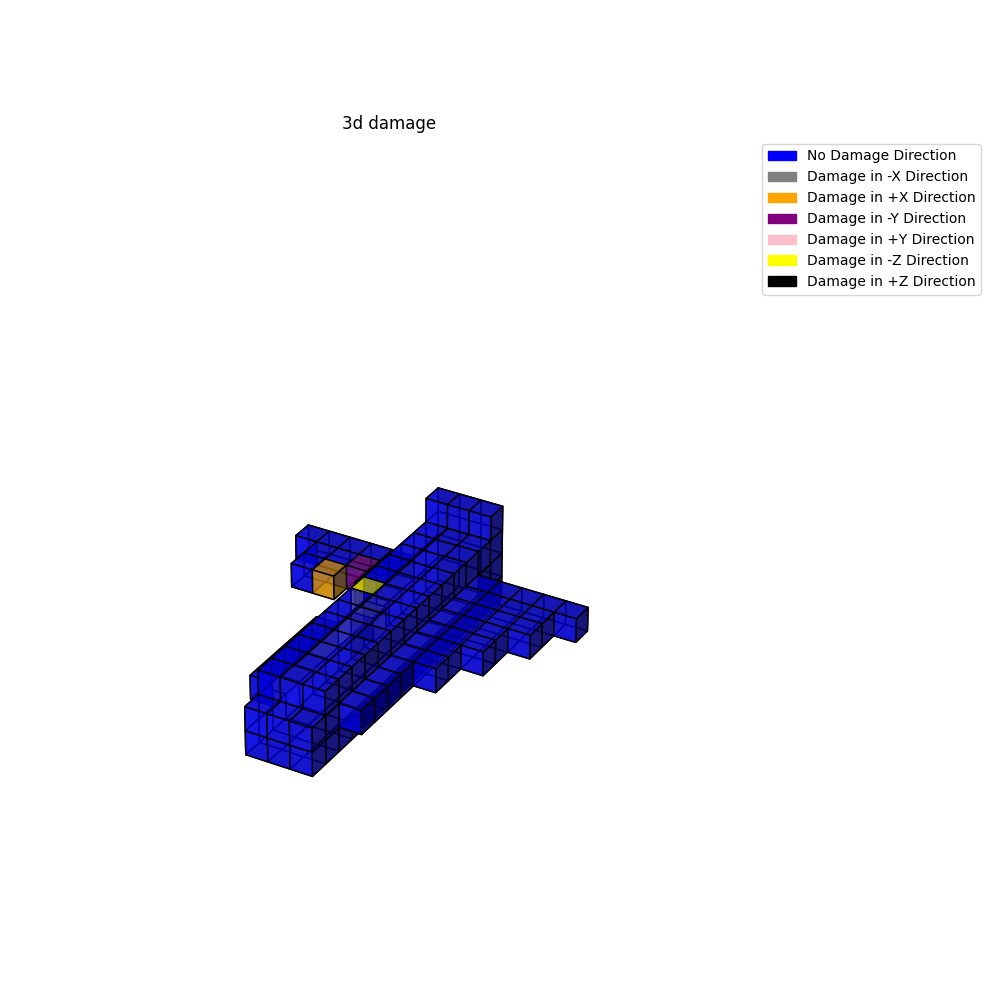

In [15]:
shape = dataset.shapes[sorted_max_indices[-2]]
damage_mask, damage_direction = dataset._generate_damage(shape, damage_type="sphere")
sphere_damage_img = plot_voxels(live_mask=damage_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8), add_shadow=False)
sphere_damage_img

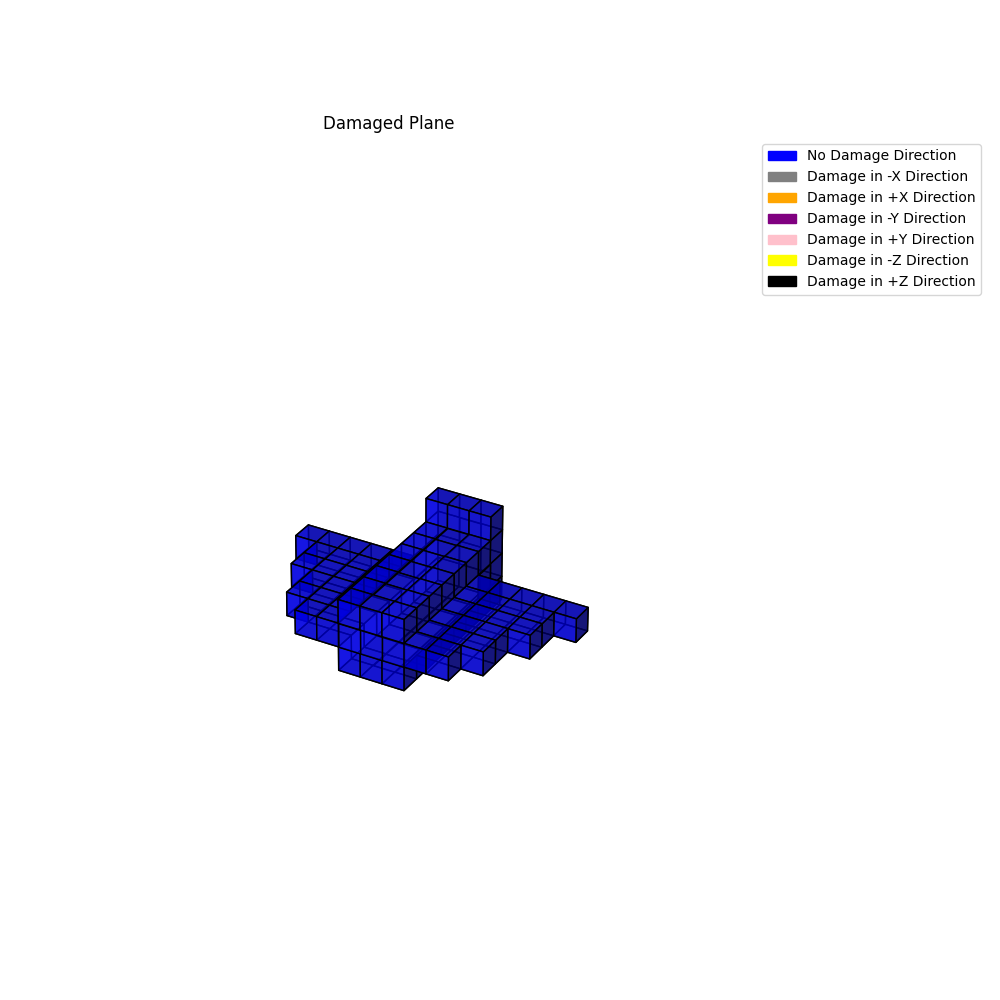

In [16]:
def label_damage_direction(shape, live_mask, new_live_mask):
    # Check each live cell to see if it's adjacent to damaged cells
    damage_direction = np.zeros_like(new_live_mask)
    # Ensure shape is a tuple of integers, not a numpy array
    shape_dims = (shape.shape[0], shape.shape[1], shape.shape[2])
    
    for x in range(shape_dims[0]):
        for y in range(shape_dims[1]):
            for z in range(shape_dims[2]):
                if new_live_mask[x, y, z] == 1:  # Only check live cells
                    # Check the 6 adjacent directions
                    if (
                        x > 0
                        and live_mask[x - 1, y, z] == 1
                        and new_live_mask[x - 1, y, z] == 0
                    ):
                        damage_direction[x, y, z] = 1  # Damage in -x direction
                    elif (
                        x < shape_dims[0] - 1
                        and live_mask[x + 1, y, z] == 1
                        and new_live_mask[x + 1, y, z] == 0
                    ):
                        damage_direction[x, y, z] = 2  # Damage in +x direction
                    elif (
                        y > 0
                        and live_mask[x, y - 1, z] == 1
                        and new_live_mask[x, y - 1, z] == 0
                    ):
                        damage_direction[x, y, z] = 3  # Damage in -y direction
                    elif (
                        y < shape_dims[1] - 1
                        and live_mask[x, y + 1, z] == 1
                        and new_live_mask[x, y + 1, z] == 0
                    ):
                        damage_direction[x, y, z] = 4  # Damage in +y direction
                    elif (
                        z > 0
                        and live_mask[x, y, z - 1] == 1
                        and new_live_mask[x, y, z - 1] == 0
                    ):
                        damage_direction[x, y, z] = 5  # Damage in -z direction
                    elif (
                        z < shape_dims[2] - 1
                        and live_mask[x, y, z + 1] == 1
                        and new_live_mask[x, y, z + 1] == 0
                    ):
                        damage_direction[x, y, z] = 6  # Damage in +z direction
    return damage_direction

def mask_shape_by_index(shape, axis=0, index=0, keep_greater=True):
    """
    Masks out parts of a 3D shape based on an index along a specified axis.
    
    Parameters:
    -----------
    shape : numpy.ndarray
        The 3D shape to mask
    axis : int, optional (default=0)
        The axis along which to apply the mask (0=x, 1=y, 2=z)
    index : int, optional (default=0)
        The index value to use as the threshold
    keep_greater : bool, optional (default=True)
        If True, keeps values where the coordinate is >= index
        If False, keeps values where the coordinate is < index
    
    Returns:
    --------
    numpy.ndarray
        A copy of the shape with the specified region masked out (set to 0)
    """
    # Create a copy of the shape to avoid modifying the original
    masked_shape = shape.copy()
    live_mask = shape.copy()
    new_live_mask = shape.copy()

    # Create a mask based on the specified axis and index
    if axis == 0:  # x-axis
        if keep_greater:
            # masked_shape[0:index, :, :] = 0
            new_live_mask[0:index, :, :] = 0
        else:
            # masked_shape[index:, :, :] = 0
            new_live_mask[index:, :, :] = 0
    elif axis == 1:  # y-axis
        if keep_greater:
            # masked_shape[:, 0:index, :] = 0
            new_live_mask[:, 0:index, :] = 0
        else:
            # masked_shape[:, index:, :] = 0
            new_live_mask[:, index:, :] = 0
    elif axis == 2:  # z-axis
        if keep_greater:
            # masked_shape[:, :, 0:index] = 0
            new_live_mask[:, :, 0:index] = 0
        else:
            # masked_shape[:, :, index:] = 0
            new_live_mask[:, :, index:] = 0
    else:
        raise ValueError(f"Invalid axis: {axis}. Must be 0, 1, or 2.")

    damage_direction = label_damage_direction(shape, live_mask, new_live_mask)
    return damage_direction, new_live_mask

# Example usage
shape = dataset.shapes[sorted_max_indices[-2]]
# Mask out the left half of the shape (x < shape.shape[0]//2)
damage_direction, new_live_mask = mask_shape_by_index(shape, axis=1, index=shape.shape[0]//2, keep_greater=True)
masked_img = plot_voxels(live_mask=new_live_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8)*0, add_shadow=False, label="Damaged Plane")
masked_img


In [17]:
shape.shape[0]//2

7

In [18]:
# Get the total number of shapes
dataset = DynamicDamageDataset(shapes, labels, damage_radius_range=(1, 3), damage_types=["sphere", "cube", "random"], random_proportion_range=(0.1, 0.2), fixed_damage=False, augment_rotations=False, return_damage_mask=True, seed=None, filter_label=0)

# Get the sizes of individual shapes
shape_sizes = [np.sum(shape) for shape in dataset.shapes]

# Print the total sum of all voxels across all shapes
print(f"Total voxels across all shapes: {sum(shape_sizes)}")

# Print some statistics about shape sizes
print(f"Average voxels per shape: {np.mean(shape_sizes):.2f}")
print(f"Min voxels in a shape: {np.min(shape_sizes)}")
print(f"Max voxels in a shape: {np.max(shape_sizes)}")

# Show the index of the shape with the minimum and maximum number of voxels
min_index = np.argmin(shape_sizes)
max_index = np.argmax(shape_sizes)
print(f"Index of shape with minimum voxels: {min_index}")
print(f"Index of shape with maximum voxels: {max_index}")
sorted_max_indices = np.argsort(shape_sizes)
print("Sorted indices of shapes by size:")
print(sorted_max_indices)

Total voxels across all shapes: 5584
Average voxels per shape: 54.21
Min voxels in a shape: 16
Max voxels in a shape: 231
Index of shape with minimum voxels: 10
Index of shape with maximum voxels: 15
Sorted indices of shapes by size:
[ 10  22  84  19  43  96  28   5  75  63 101  34  17   0  62  92  48  40
  69  33  59  21  56  47  81  86  51  25  65  57  11 102  13  55  49  99
  93   7   8   6  67  16  27  32  71  26   2  89  50  45  41  85  12  30
  77  36  94  18  60  79  98  52  73  95  20   1  53  88  29   9  82  70
  24  80   3  87  38  58  72  91  14  61  64 100  44  66  90  46  31  23
  74  54  68  42  39   4  78  83  37  35  97  76  15]


In [19]:
def add_border_cells_to_live_mask(live_mask, damage_direction):
    """
    Creates a copy of the live mask and adds cells where damage direction > 0.
    
    Args:
        live_mask: 3D numpy array representing the current live mask
        damage_direction: 3D numpy array representing the damage direction
    
    Returns:
        updated_live_mask: 3D numpy array with border cells added
        updated_damage_direction: 3D numpy array with damage direction updated
    """
    # Create a copy of the live mask
    updated_live_mask = live_mask.copy()
    
    # Find cells where damage direction is greater than 0
    border_cells = damage_direction > 0
    
    # Add cells in the direction indicated by damage_direction
    # Damage direction values: 1: (x-1,y,z), 2: (x+1,y,z), 3: (x,y-1,z), 4: (x,y-1,z), 5: (x,y+1,z), 6: (x,y,z-1), 7: (x,y,z+1)
    x, y, z = np.where(damage_direction > 0)
    directions = damage_direction[x, y, z]
    # Create arrays to store the new positions
    new_positions = []
    
    for i in range(len(x)):
        dx, dy, dz = 0, 0, 0
        if directions[i] == 1:  # (x-1,y,z)
            dx = -1
        elif directions[i] == 2:  # (x+1,y,z)
            dx = 1
        elif directions[i] == 3:  # (x,y-1,z)
            dy = -1
        elif directions[i] == 4:  # (x,y+1,z)
            dy = 1
        elif directions[i] == 5:  # (x,y,z-1)
            dz = -1
        elif directions[i] == 6:  # (x,y,z+1)
            dz = 1
        # Calculate new position
        nx, ny, nz = x[i] + dx, y[i] + dy, z[i] + dz
        
        # Check if the new position is within bounds
        if (0 <= nx < updated_live_mask.shape[0] and 
            0 <= ny < updated_live_mask.shape[1] and 
            0 <= nz < updated_live_mask.shape[2]):
            updated_live_mask[nx, ny, nz] = 1
            new_positions.append((nx, ny, nz))
    
    # Create a string representation of the direction for each added cell
    direction_names = {1: "-x", 2: "+x", 3: "-y", 4: "+y", 5: "-z", 6: "+z"}
    directions_added = []
    for dir_val in range(1, 7):
        cells_in_dir = (damage_direction == dir_val).sum()
        if cells_in_dir > 0:
            directions_added.append(f"{direction_names[dir_val]}: {cells_in_dir} cells")
    
    if directions_added:
        print(f"Added cells in directions: {', '.join(directions_added)}")
        print(f"Total cells added: {len(new_positions)}")
    
    # Update the damage direction to zero where we've processed cells
    updated_damage_direction = damage_direction.copy()
    updated_damage_direction[border_cells] = 0
    
    return updated_live_mask, updated_damage_direction


In [ ]:
# Example usage
shape = dataset.shapes[sorted_max_indices[-2]]
original_live_mask = shape
images = []
damage_direction, new_live_mask = mask_shape_by_index(shape, axis=1, index=4, keep_greater=True)
damage_directions = []
live_masks = []

for i in range(0,4):
    # Mask out the left half of the shape (x < shape.shape[0]//2)
    new_live_mask, damage_direction = add_border_cells_to_live_mask(new_live_mask, damage_direction)
    damage_direction = label_damage_direction(shape, shape, new_live_mask)

    phase = i+1
    if i == 3:
        label = "NCA predictions last phase"
    else:
        label = f"NCA predictions phase {phase}"
    masked_img = plot_voxels(live_mask=new_live_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8), add_shadow=False, label=label)
    images.append(masked_img)

# masked_img = plot_voxels(live_mask=shape, damage_direction=damage_direction.astype(np.uint8) * 0, add_shadow=False, label=f"NCA predictions last phase")
# images = images[::-1]
# images.append(masked_img)


Added cells in directions: -y: 11 cells
Total cells added: 11
Added cells in directions: -y: 11 cells
Total cells added: 11
Added cells in directions: -y: 9 cells
Total cells added: 9
Added cells in directions: -y: 6 cells
Total cells added: 6


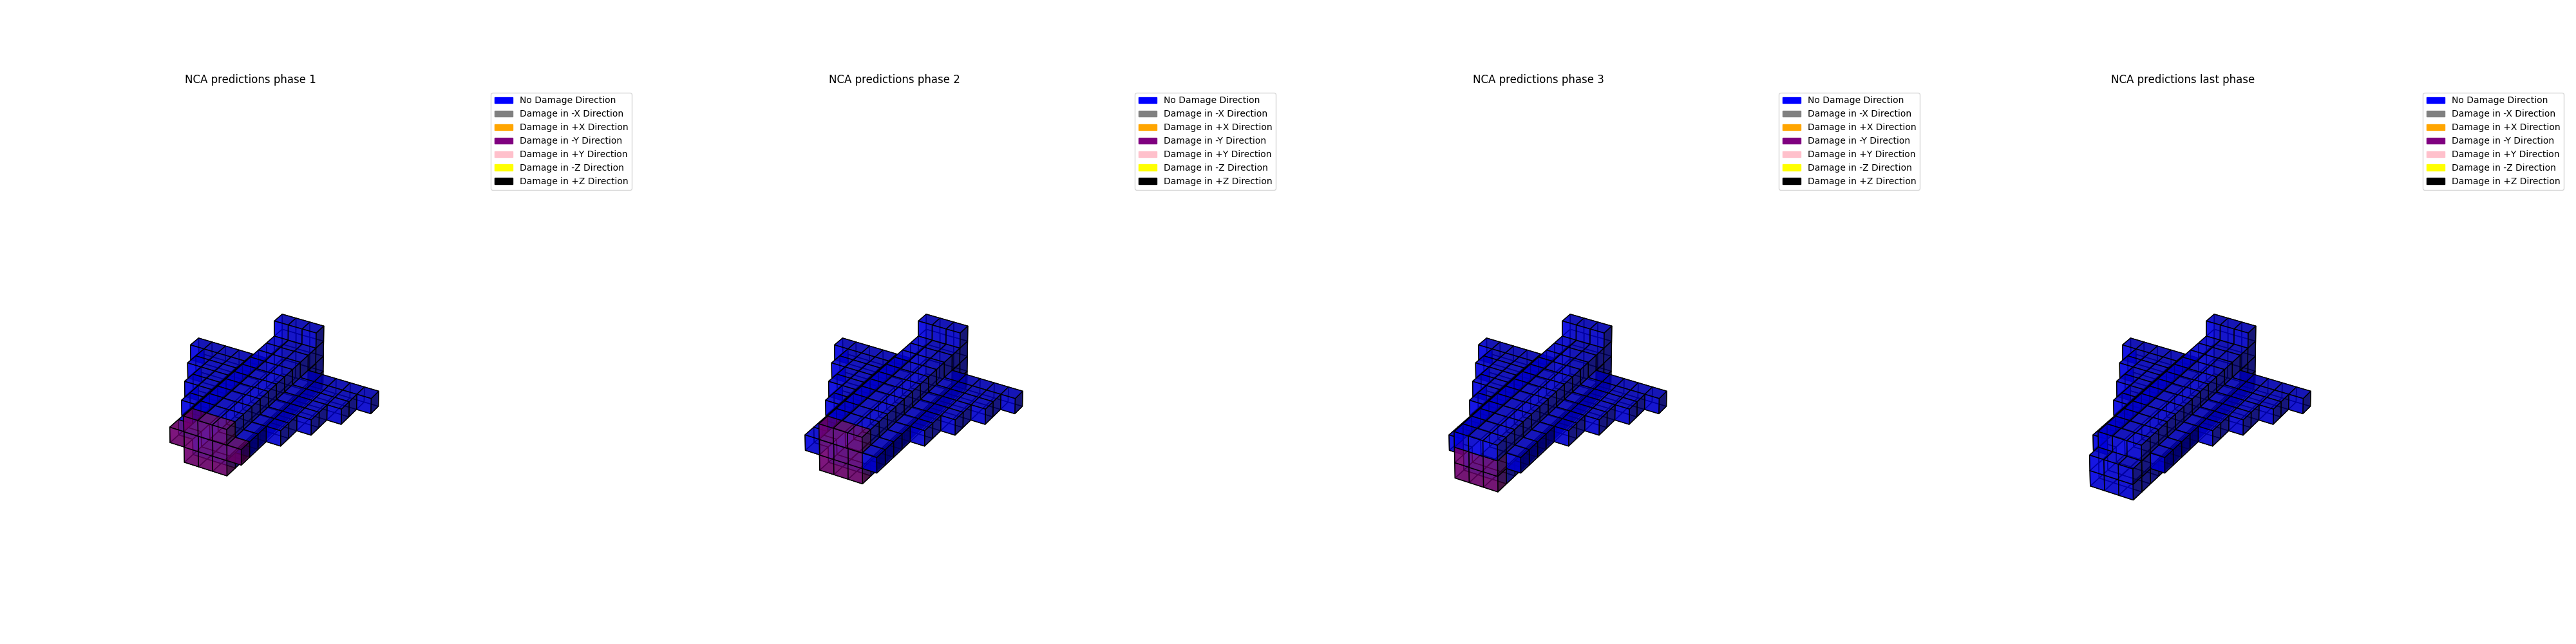

In [21]:
def combine_images(images, horizontal=True):
    """
    Combine multiple PIL images into a single image, either horizontally or vertically.
    
    Args:
        images: List of PIL images to combine
        horizontal: If True, combine horizontally, otherwise vertically
    
    Returns:
        A single PIL image containing all input images
    """
    if not images:
        return None
    
    # Ensure all images are PIL images
    pil_images = [img if isinstance(img, Image.Image) else Image.fromarray(np.array(img)) for img in images]
    
    if horizontal:
        # For horizontal arrangement, find the max height
        width = sum(img.width for img in pil_images)
        height = max(img.height for img in pil_images)
        
        # Create a new blank image
        combined = Image.new('RGBA', (width, height))
        
        # Paste each image
        x_offset = 0
        for img in pil_images:
            combined.paste(img, (x_offset, 0), img if img.mode == 'RGBA' else None)
            x_offset += img.width
    else:
        # For vertical arrangement, find the max width
        width = max(img.width for img in pil_images)
        height = sum(img.height for img in pil_images)
        
        # Create a new blank image
        combined = Image.new('RGBA', (width, height))
        
        # Paste each image
        y_offset = 0
        for img in pil_images:
            combined.paste(img, (0, y_offset), img if img.mode == 'RGBA' else None)
            y_offset += img.height
    
    return combined

# Display one of the images
combine_images(images=images)

In [22]:
plot_voxels(live_mask=live_masks[0].astype(np.uint8), damage_direction=damage_directions[0].astype(np.uint8), add_shadow=False, label=f"NCA predictions phase {phase}")

IndexError: list index out of range

In [23]:
updated_live_mask, updated_damage_direction = add_border_cells_to_live_mask(live_masks[0], damage_direction)
plot_voxels(live_mask=updated_live_mask.astype(np.uint8), damage_direction=updated_damage_direction.astype(np.uint8), add_shadow=False, label=f"NCA predictions phase {phase}")

IndexError: list index out of range

In [24]:
new_damage_direction = label_damage_direction(shape, shape, updated_live_mask)
updated_live_mask, updated_damage_direction = add_border_cells_to_live_mask(updated_live_mask, new_damage_direction)
plot_voxels(live_mask=updated_live_mask.astype(np.uint8), damage_direction=updated_damage_direction.astype(np.uint8), add_shadow=False, label=f"NCA predictions phase {phase}")

NameError: name 'updated_live_mask' is not defined

In [25]:
updated_live_mask, updated_damage_direction = add_border_cells_to_live_mask(updated_live_mask, new_damage_direction)
plot_voxels(live_mask=updated_live_mask.astype(np.uint8), damage_direction=updated_damage_direction.astype(np.uint8)*0, add_shadow=False, label=f"NCA predictions phase {phase}")

NameError: name 'updated_live_mask' is not defined

In [26]:
new_damage_direction = label_damage_direction(shape, shape, updated_live_mask)
plot_voxels(live_mask=updated_live_mask.astype(np.uint8), damage_direction=new_damage_direction.astype(np.uint8), add_shadow=False, label=f"NCA predictions phase {phase}")

NameError: name 'updated_live_mask' is not defined

In [27]:
updated_live_mask, updated_damage_direction = add_border_cells_to_live_mask(updated_live_mask, updated_damage_direction)
plot_voxels(live_mask=updated_live_mask.astype(np.uint8), damage_direction=updated_damage_direction.astype(np.uint8), add_shadow=False, label=f"NCA predictions phase {phase}")

NameError: name 'updated_live_mask' is not defined

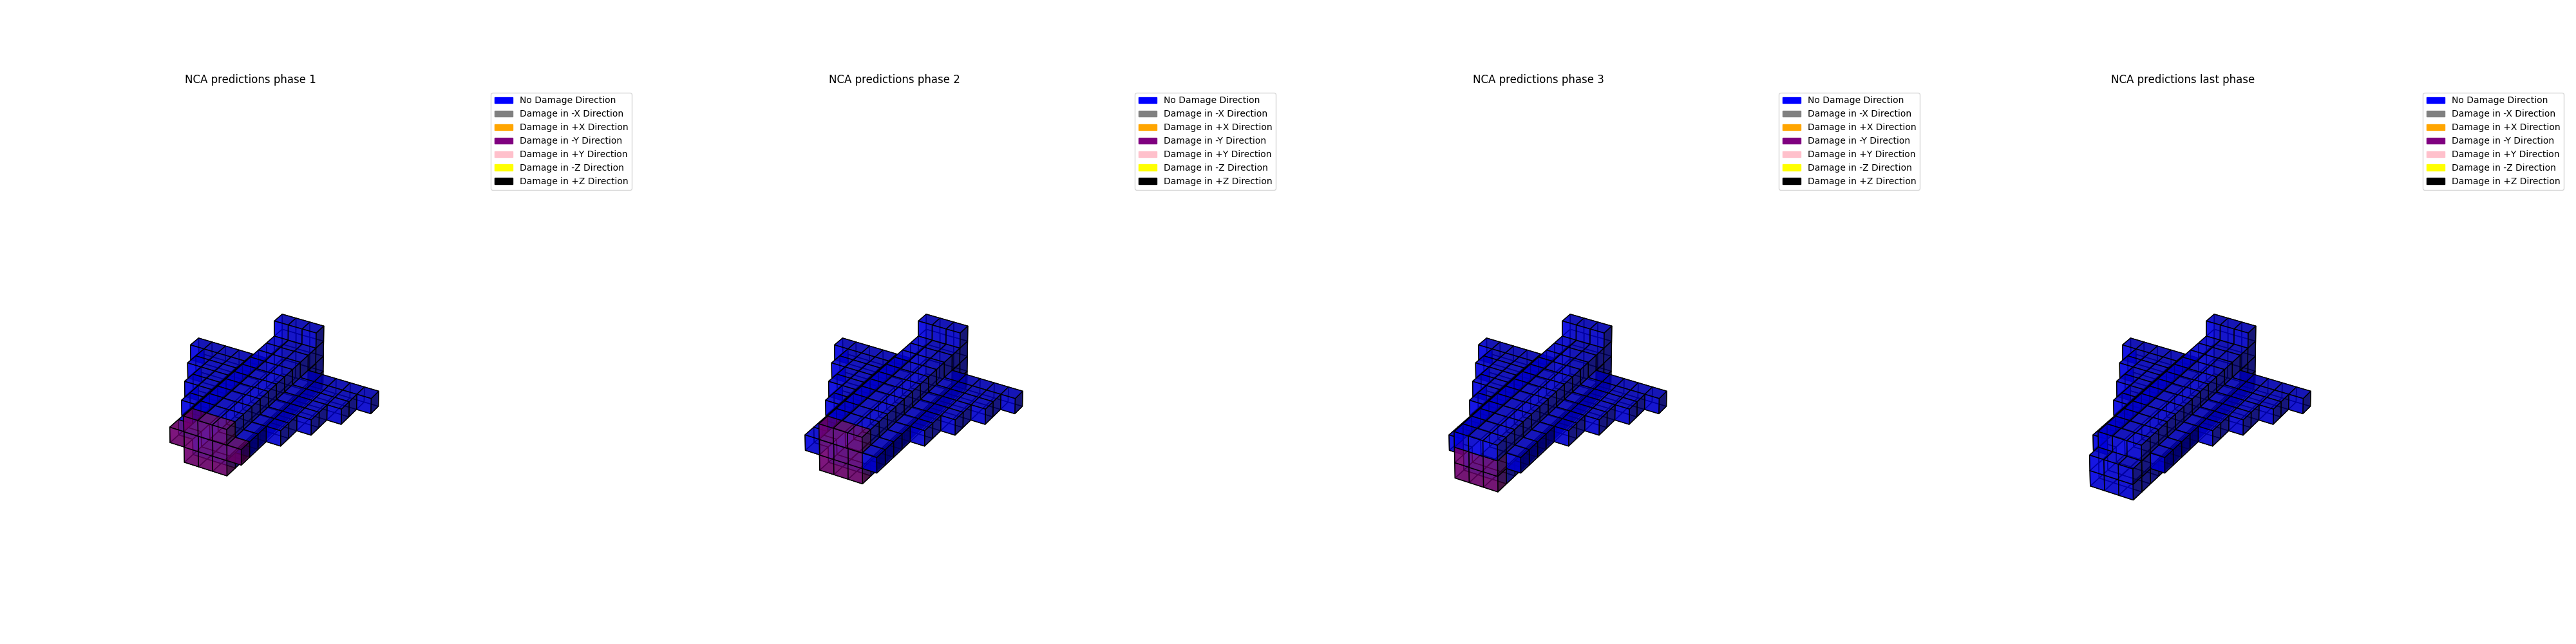

In [28]:
# Concatenate all images horizontally into one PIL image
from PIL import Image
import numpy as np

# Convert all images to PIL if they aren't already
pil_images = [img if isinstance(img, Image.Image) else Image.fromarray(img) for img in images]

# Get the total width and maximum height
total_width = sum(img.width for img in pil_images)
max_height = max(img.height for img in pil_images)

# Create a new blank image with the total width and max height
concatenated_image = Image.new('RGBA', (total_width, max_height))

# Paste each image next to each other
x_offset = 0
for img in pil_images:
    concatenated_image.paste(img, (x_offset, 0))
    x_offset += img.width

# Display the concatenated image
concatenated_image


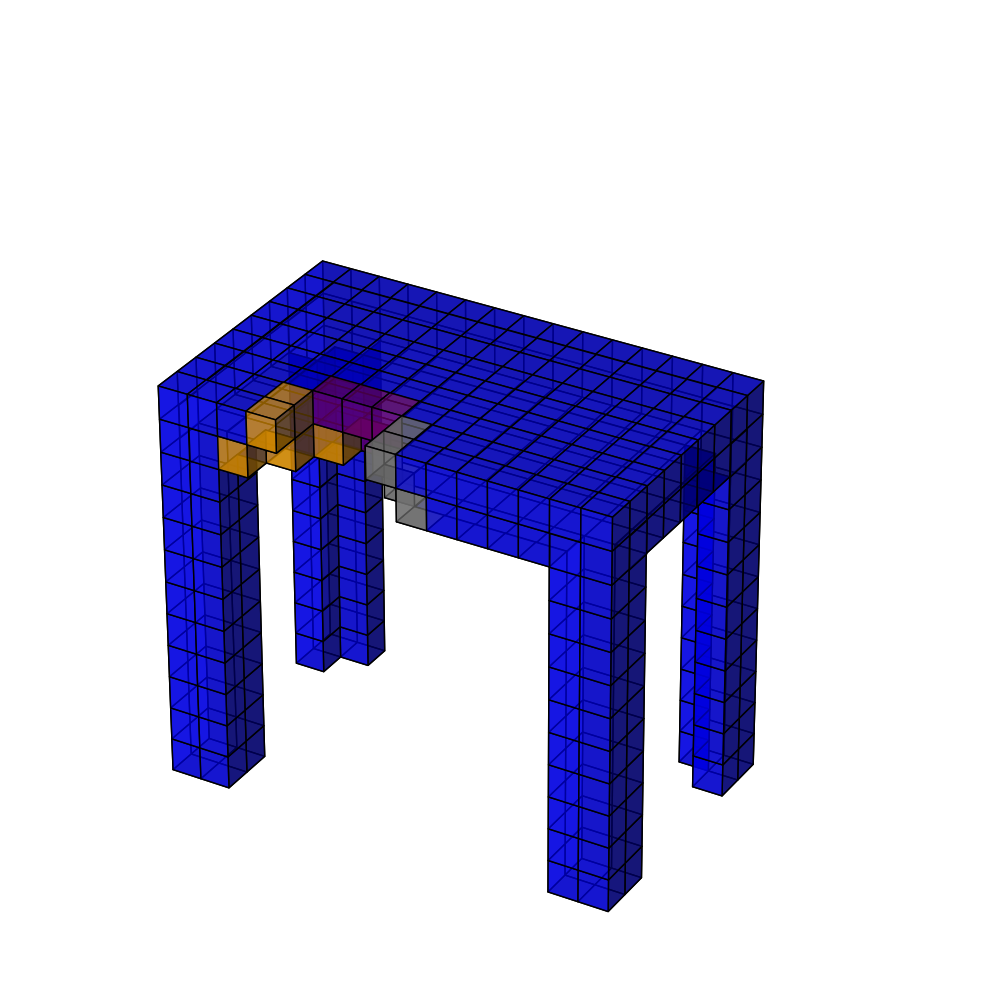

In [62]:
dataset = DynamicDamageDataset(shapes, labels, damage_radius_range=(2, 3), damage_types=["sphere", "cube", "random"], random_proportion_range=(0.1, 0.2), fixed_damage=False, augment_rotations=False, return_damage_mask=True, seed=None, filter_label=3)
shape = dataset.shapes[0]

damage_mask, damage_direction = dataset._generate_damage(shape, damage_type="sphere")
sphere_no_damage_img = plot_voxels(live_mask=damage_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8)*0, add_shadow=False, label=None, legend=False)
sphere_damage_img = plot_voxels(live_mask=damage_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8), add_shadow=False, label=None, legend=False)
sphere_damage_img

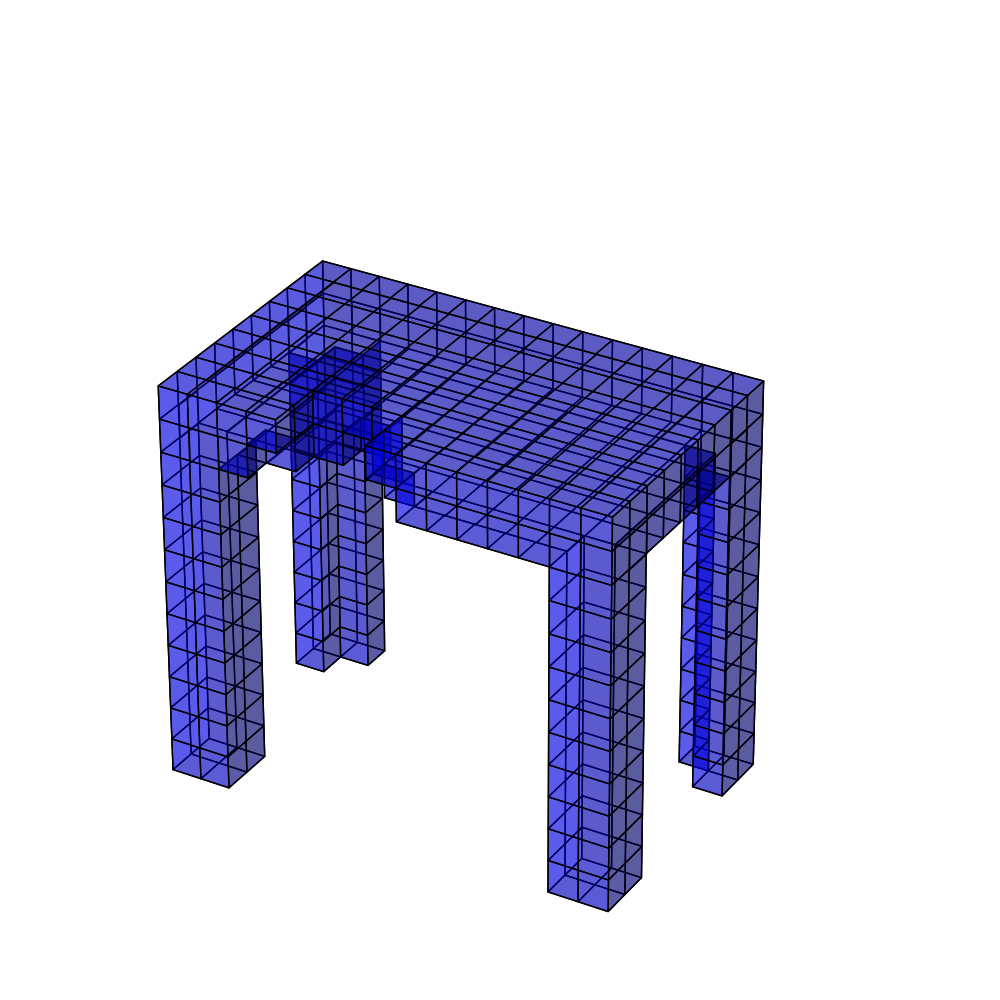

In [70]:
sphere_no_damage_img = plot_voxels(live_mask=damage_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8)*0, add_shadow=False, label=None, legend=False, alpha=0.4)
sphere_no_damage_img

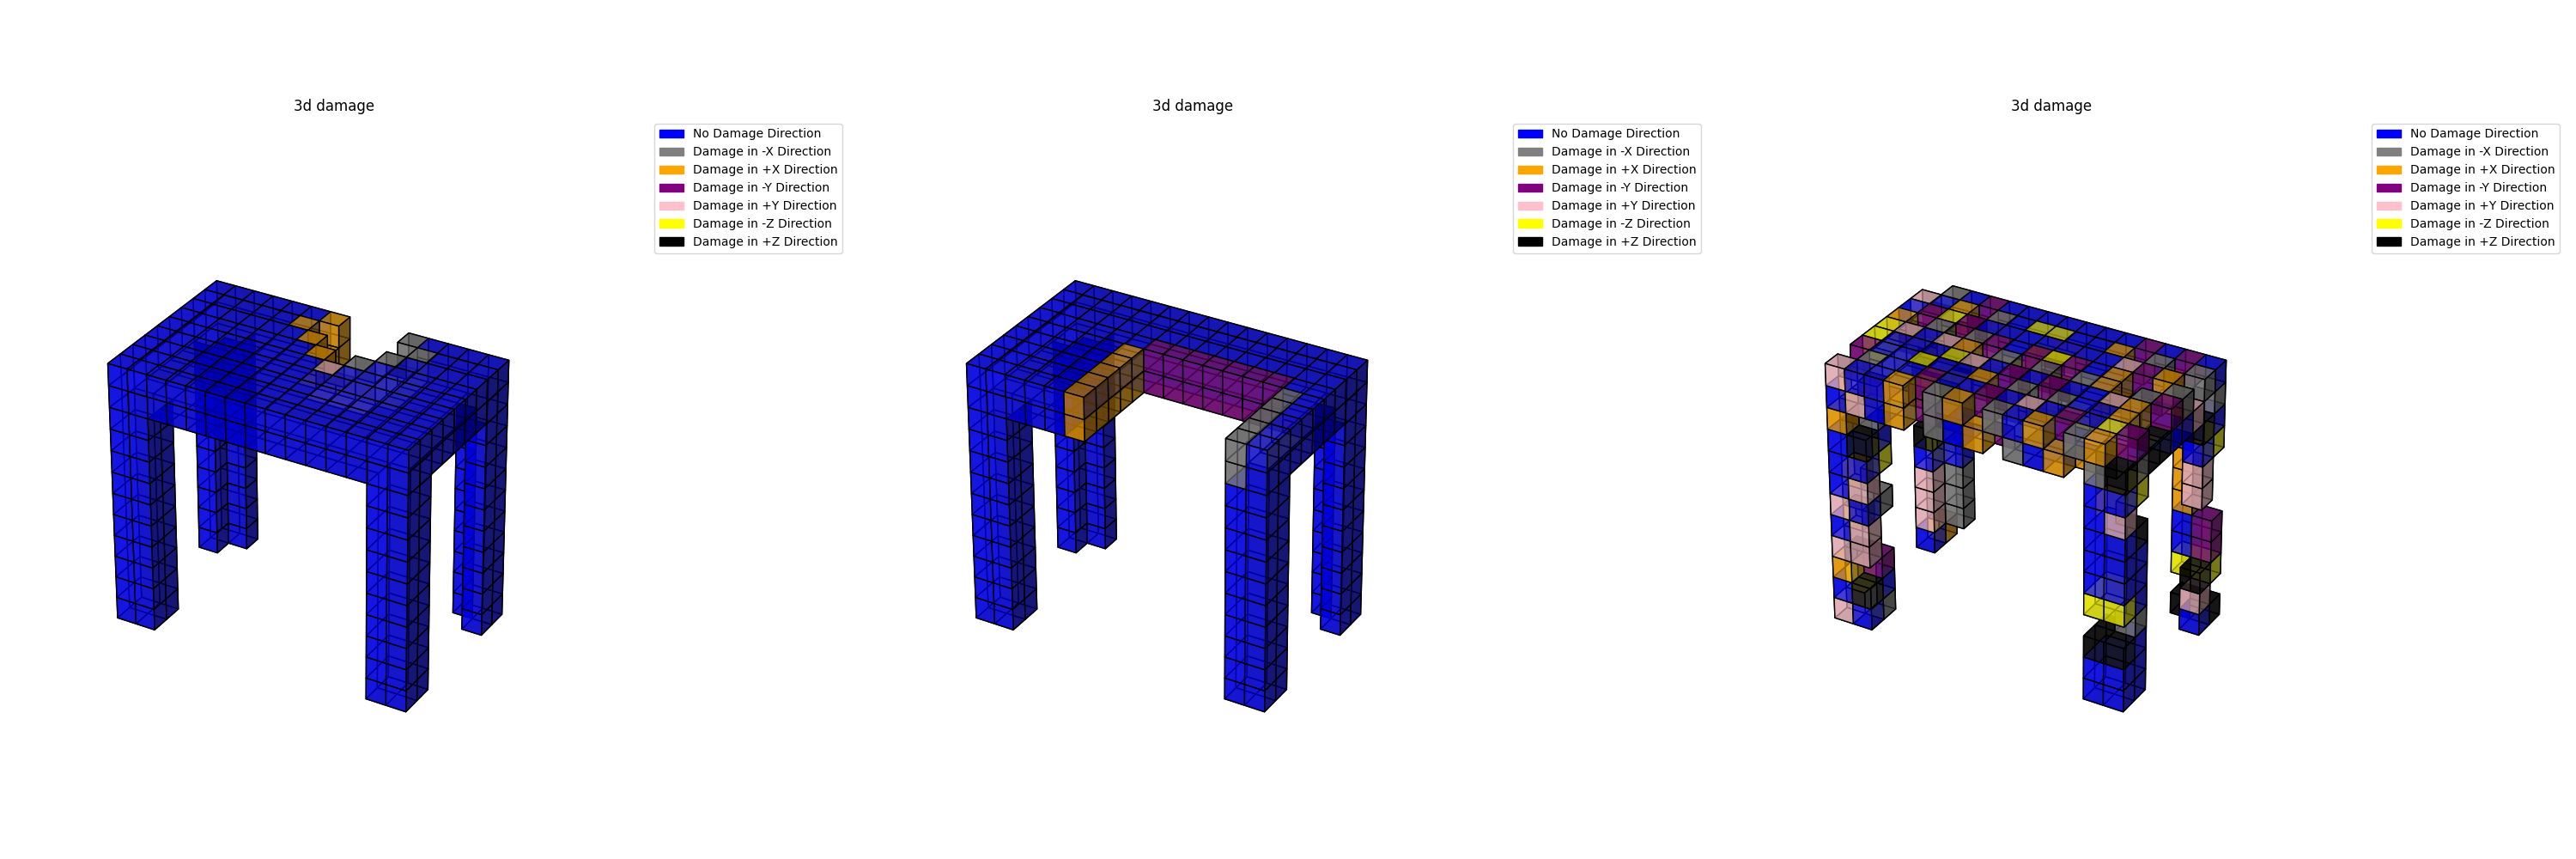

In [29]:
# Combine sphere, cube, and random damage images side by side
from PIL import Image

dataset = DynamicDamageDataset(shapes, labels, damage_radius_range=(2, 3), damage_types=["sphere", "cube", "random"], random_proportion_range=(0.1, 0.2), fixed_damage=False, augment_rotations=False, return_damage_mask=True, seed=None, filter_label=3)
shape = dataset.shapes[0]

damage_mask, damage_direction = dataset._generate_damage(shape, damage_type="sphere")
sphere_damage_img = plot_voxels(live_mask=damage_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8), add_shadow=False)

damage_mask, damage_direction = dataset._generate_damage(shape, damage_type="cube")
cube_damage_img = plot_voxels(live_mask=damage_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8), add_shadow=False)

damage_mask, damage_direction = dataset._generate_damage(shape, damage_type="random")
random_damage_img = plot_voxels(live_mask=damage_mask.astype(np.uint8), damage_direction=damage_direction.astype(np.uint8), add_shadow=False)

# Calculate combined dimensions
combined_width = sphere_damage_img.width + cube_damage_img.width + random_damage_img.width
combined_height = max(sphere_damage_img.height, cube_damage_img.height, random_damage_img.height)

# Create a new image with the combined dimensions
combined_img = Image.new('RGBA', (combined_width, combined_height))

# Paste each image at the appropriate position
combined_img.paste(sphere_damage_img, (0, 0))
combined_img.paste(cube_damage_img, (sphere_damage_img.width, 0))
combined_img.paste(random_damage_img, (sphere_damage_img.width + cube_damage_img.width, 0))

# Display the combined image
combined_img


In [8]:
# Function to add noise to an array and clip to a specified range
def add_noise_and_clip(array, noise_level=0.1, min_val=0.0, max_val=1.0):
    """
    Add random noise to an array and clip values to a specified range.
    
    Args:
        array (numpy.ndarray): Input array
        noise_level (float): Standard deviation of the Gaussian noise (default: 0.1)
        min_val (float): Minimum value after clipping (default: 0.0)
        max_val (float): Maximum value after clipping (default: 1.0)
        
    Returns:
        numpy.ndarray: Array with added noise and clipped values
    """
    # Generate random noise with the same shape as the input array
    noise = np.random.normal(0, noise_level, array.shape)
    
    # Add noise to the array
    noisy_array = array + noise
    
    # Clip values to the specified range
    clipped_array = np.clip(noisy_array, min_val, max_val)
    return clipped_array

def generate_increasing_array(size, start=0.0, end=1.0, noise_level=0.1, min_val=0.0, max_val=1.0):
    """
    Generate a steadily increasing array from start to end value.
    
    Args:
        size (int or tuple): Size of the output array
        start (float): Starting value (default: 0.0)
        end (float): Ending value (default: 1.0)
        
    Returns:
        numpy.ndarray: Array with steadily increasing values
    """
    if isinstance(size, int):
        # 1D array
        return np.linspace(start, end, size)
    elif isinstance(size, tuple):
        # Multi-dimensional array
        total_elements = np.prod(size)
        flat_array = np.linspace(start, end, total_elements)
        return flat_array.reshape(size)
    else:
        raise ValueError("Size must be an integer or tuple")
def generate_exponential_array(size, start=0.01, end=1.0, base=10, momentum=1.0, noise_level=0.0, min_val=None, max_val=None, 
                              undulation_frequency=8, undulation_amplitude=0.02, jitter_scale=0.05):
    """
    Generate an exponentially increasing array from start to end value with optional noise.
    
    Args:
        size (int or tuple): Size of the output array
        start (float): Starting value (default: 0.01)
        end (float): Ending value (default: 1.0)
        base (float): Base of the exponential function (default: 10)
        momentum (float): Scale factor to control how quickly values increase (default: 1.0)
                         Higher values make the curve steeper in the middle
        noise_level (float): Standard deviation of the Gaussian noise (default: 0.0)
        min_val (float): Minimum value after clipping (default: None)
        max_val (float): Maximum value after clipping (default: None)
        undulation_frequency (float): Frequency of sine wave undulations (default: 8)
        undulation_amplitude (float): Amplitude of sine wave undulations (default: 0.02)
        jitter_scale (float): Scale of random jitter applied to progression (default: 0.05)
        
    Returns:
        numpy.ndarray: Array with exponentially increasing values and optional noise
    """
    if isinstance(size, int):
        # 1D array
        # Generate linear space in log domain
        log_start = np.log(start) / np.log(base)
        log_end = np.log(end) / np.log(base)
        
        # Apply momentum to create more natural progression
        t = np.linspace(0, 1, size)
        # Add small random variations to make progression more natural
        t = t + np.random.normal(0, 0.01, size) * jitter_scale
        t = np.clip(t, 0, 1)  # Keep within valid range
        
        # Apply momentum transformation with slight randomness
        momentum_jitter = momentum * (1 + np.random.normal(0, 0.05))
        t_momentum = np.power(t, momentum_jitter)
        
        # Add small undulations to make curve more natural
        undulation = np.sin(t * undulation_frequency * np.pi) * undulation_amplitude
        t_momentum = t_momentum + undulation
        log_space = log_start + (log_end - log_start) * t_momentum
        # Convert back to linear domain
        exp_array = np.power(base, log_space)
    elif isinstance(size, tuple):
        # Multi-dimensional array
        total_elements = np.prod(size)
        log_start = np.log(start) / np.log(base)
        log_end = np.log(end) / np.log(base)
        
        # Create natural progression with variations
        t = np.linspace(0, 1, total_elements)
        t = t + np.random.normal(0, 0.01, total_elements) * 0.05
        t = np.clip(t, 0, 1)
        
        # Apply momentum with natural variations
        momentum_jitter = momentum * (1 + np.random.normal(0, 0.05))
        t_momentum = np.power(t, momentum_jitter)
        
        # Add natural undulations
        undulation = np.sin(t * 8 * np.pi) * 0.02
        t_momentum = t_momentum + undulation
        
        log_space = log_start + (log_end - log_start) * t_momentum
        exp_array = np.power(base, log_space).reshape(size)
    else:
        raise ValueError("Size must be an integer or tuple")
    
    # Add noise if specified for more natural appearance
    if noise_level > 0:
        # Use non-uniform noise that scales with values for more natural look
        scaled_noise = np.random.normal(0, noise_level, exp_array.shape) * exp_array * 0.3
        exp_array = exp_array + scaled_noise
    
    # Clip values if specified
    if min_val is not None or max_val is not None:
        exp_array = np.clip(exp_array, min_val, max_val)
        
    return exp_array

# Example usage
increasing_array_1d = generate_increasing_array(5000)
print("1D increasing array:")
print(increasing_array_1d)

increasing_array_3d = generate_increasing_array((3, 3, 3))
print("\n3D increasing array:")
print(increasing_array_3d)


1D increasing array:
[0.00000000e+00 2.00040008e-04 4.00080016e-04 ... 9.99599920e-01
 9.99799960e-01 1.00000000e+00]

3D increasing array:
[[[0.         0.03846154 0.07692308]
  [0.11538462 0.15384615 0.19230769]
  [0.23076923 0.26923077 0.30769231]]

 [[0.34615385 0.38461538 0.42307692]
  [0.46153846 0.5        0.53846154]
  [0.57692308 0.61538462 0.65384615]]

 [[0.69230769 0.73076923 0.76923077]
  [0.80769231 0.84615385 0.88461538]
  [0.92307692 0.96153846 1.        ]]]


In [ ]:
# Plot all arrays together
import matplotlib.pyplot as plt
from IPython.display import display

plt.figure(figsize=(14, 8))

# Plot each array with different colors and labels
plt.plot(plane_array, linestyle='-', color='blue', linewidth=1.5, label=f'Plane Test Accuracy (97%)')
plt.plot(car_array, linestyle='-', color='red', linewidth=1.5, label=f'Car Test Accuracy (92%)')
plt.plot(chair_array, linestyle='-', color='green', linewidth=1.5, label=f'Chair Test Accuracy (93%)')
plt.plot(table_array, linestyle='-', color='purple', linewidth=1.5, label=f'Table Test Accuracy (94%)')
plt.plot(building_array, linestyle='-', color='orange', linewidth=1.5, label=f'Building Test Accuracy (98%)')

# Add title and labels
plt.title('Test Accuracy on Different Shapes', fontsize=16)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=24)

# Add styling
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0, 1.0)  # Set y-axis range between 0 and 1.2
plt.tight_layout()

# Show the plot
plt.show()


NameError: name 'plane_array' is not defined

<Figure size 1400x800 with 0 Axes>

In [ ]:
# Create two images
damage_mask_tensor, damage_direction_tensor, label, original_shape = dataset[26]
original_shape_img = plot_voxels(live_mask=original_shape.numpy().astype(np.uint8), damage_direction=original_shape.numpy().astype(np.uint8))
damage_img = plot_voxels(live_mask=damage_mask_tensor.numpy().astype(np.uint8), damage_direction=0*damage_direction_tensor.numpy().astype(np.uint8))

# Combine images side by side
from PIL import Image
combined_width = original_shape_img.width + damage_img.width
combined_height = max(original_shape_img.height, damage_img.height)
combined_img = Image.new('RGBA', (combined_width, combined_height))
combined_img.paste(original_shape_img, (0, 0))
combined_img.paste(damage_img, (original_shape_img.width, 0))

# Display the combined image
combined_img

In [106]:
damage_img = plot_voxels(live_mask=original_shape.numpy().astype(np.uint8), damage_direction=original_shape.numpy().astype(np.uint8), add_shadow=False)

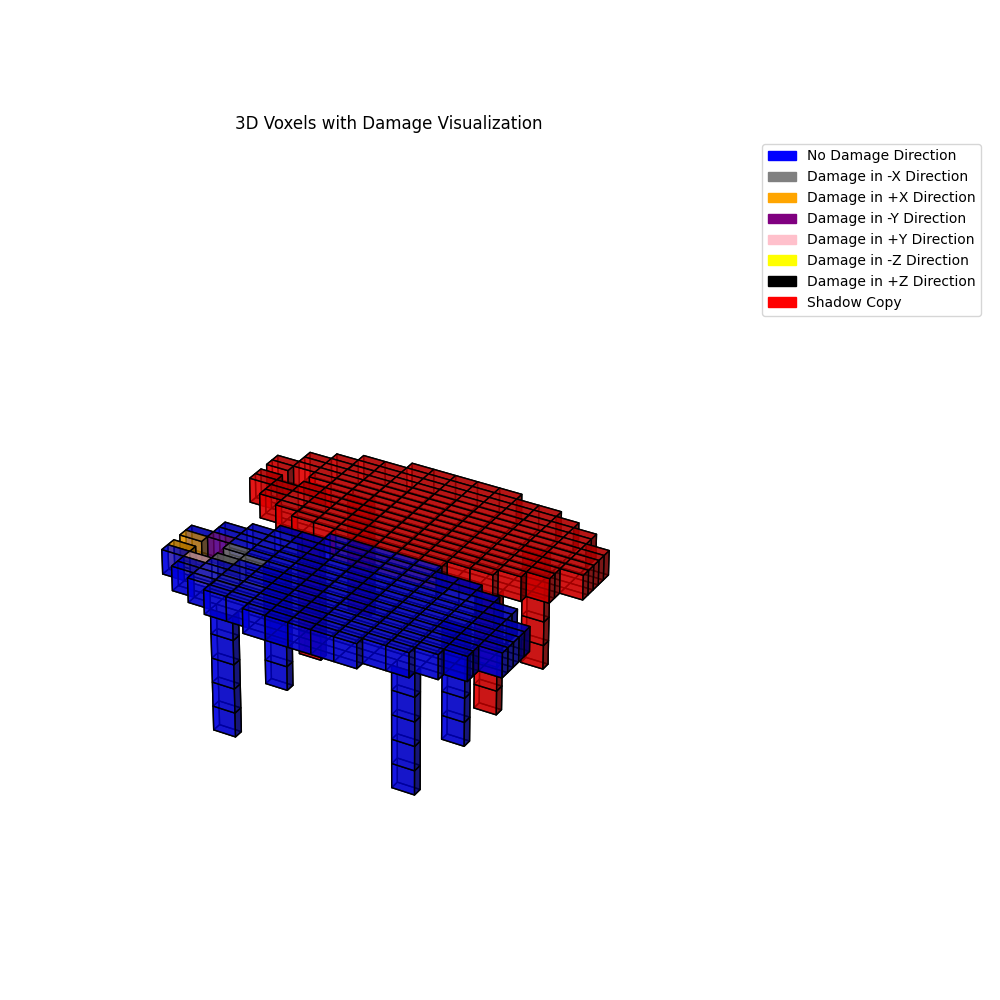

In [15]:
damage_img

In [114]:
damage_img = plot_voxels(live_mask=original_shape.numpy().astype(np.uint8), damage_direction=0*damage_direction_tensor.numpy().astype(np.uint8), add_shadow=False)


In [ ]:
damage_img

#### Train

In [66]:
model = NCA3DDamageDetection()

In [ ]:
save_weights(model, 0)

In [6]:
trainer = NCA3DTrainer(model, dataset, batch_size=1, lr=0.0001, iterations_per_epoch=100, steps_per_sample=96, buffer_size=1000, buffer_sampling_prob=0.5)

In [ ]:
trainer.train(epochs=100, save_frequency=10, visualization_frequency=10)